Loaded shape: (3276, 5)
Label distribution:
 Status
Average    1321
High       1221
Low         734
Name: count, dtype: int64
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best params: {'clf__max_depth': 10, 'clf__n_estimators': 200}
Test Accuracy: 0.9985

Classification report:
               precision    recall  f1-score   support

     Average       1.00      1.00      1.00       265
        High       1.00      1.00      1.00       244
         Low       1.00      1.00      1.00       147

    accuracy                           1.00       656
   macro avg       1.00      1.00      1.00       656
weighted avg       1.00      1.00      1.00       656

Saved trained model to tap_water.pkl


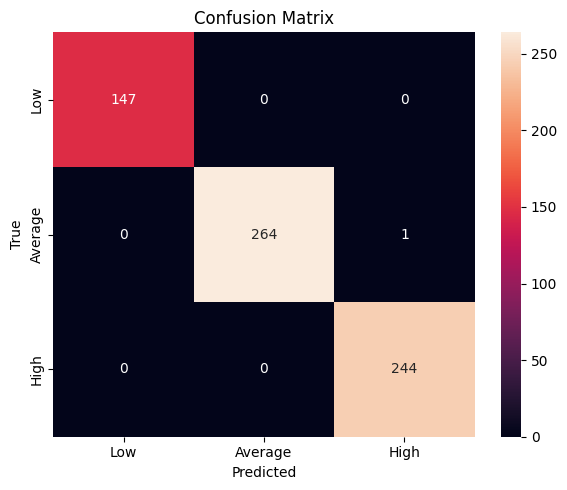

In [ ]:

"""
End-to-end model training script for Tap Water Quality Classification.

Goal:
- Input: 5 numerical features about water:
    1. ph
    2. Hardness
    3. Chloramines
    4. Sulfate
    5. Turbidity
- Output: Class label -> "Low", "Average", "High" (overall quality status)

Main steps:
1. Load CSV
2. Clean data (numeric + fill missing with median)
3. Create Status label based on given threshold rules
4. Train/test split
5. Build ML pipeline (Imputer -> Scaler -> Random Forest)
6. Hyperparameter tuning with GridSearchCV
7. Evaluate (accuracy, classification report, confusion matrix plot)
8. Save final best model as 'tap_water.pkl'
"""

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------
# Global constants
# ---------------------------

RANDOM_STATE = 42

# CSV file containing your raw water data
DATA_PATH = "water_potability.csv"

# Path where trained model will be saved
MODEL_PATH = "tap_water.pkl"   # <--- as you requested



# ---------------------------
# 1. Load dataset & select columns
# ---------------------------

# Only these features will be used for training
cols = ["ph", "Hardness", "Chloramines", "Sulfate", "Turbidity"]

# Read the CSV file into a DataFrame
df = pd.read_csv(DATA_PATH)

# Keep only the selected columns and create a copy to avoid warnings
df = df[cols].copy()
print("Loaded shape:", df.shape)

# ---------------------------
# 2. Clean & create label using your thresholds
# ---------------------------

# Ensure all selected columns are numeric.
# If any non-numeric values are present, they become NaN (using errors='coerce')
for c in cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Handle missing values:
# We fill NaN values with the median of that column (as per your requirement).
for c in cols:
    df[c] = df[c].fillna(df[c].median())

def categorize(value: float, low: float, high: float) -> str:
    """
    Categorize a single numeric value into:
        - "Low"     if value < low
        - "High"    if value > high
        - "Average" otherwise (between low and high inclusive)
    """
    if value < low:
        return "Low"
    elif value > high:
        return "High"
    else:
        return "Average"

def get_status(row) -> str:
    """
    For each row (sample), we:
      1. Categorize each parameter into Low / Average / High
         using your provided ranges.
      2. Derive an overall Status:
         - If ANY parameter is "High"        -> Status = "High"
         - ELSE if ANY parameter is "Low"    -> Status = "Low"
         - ELSE                              -> Status = "Average"
    """
    statuses = [
        categorize(row["ph"],          5.11,  9.07),
        categorize(row["Hardness"],    154.5, 235.8),
        categorize(row["Chloramines"], 5.19,  9.14),
        categorize(row["Sulfate"],     283.2, 384.8),
        categorize(row["Turbidity"],   2.94,  4.96),
    ]

    # Priority: "High" > "Low" > "Average"
    if "High" in statuses:
        return "High"
    elif "Low" in statuses:
        return "Low"
    else:
        return "Average"

# Apply get_status row-wise to create the final label column "Status"
df["Status"] = df.apply(get_status, axis=1)

print("Label distribution:\n", df["Status"].value_counts())

# ---------------------------
# 3. Prepare features (X) and labels (y)
# ---------------------------

# X = feature matrix (input to the model)
X = df[cols].copy()

# y = labels / target (Low, Average, High)
y = df["Status"].copy()

# ---------------------------
# 4. Train / Test split
# ---------------------------
# test_size=0.2 -> 20% data for testing, 80% for training
# stratify=y    -> maintain same class ratio in train and test
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

# ---------------------------
# 5. Define ML pipeline
# ---------------------------

# Pipeline steps:
# 1. SimpleImputer -> fill missing values with median (for safety, though we already did)
# 2. StandardScaler -> scale features to mean 0, std 1 (helps many models)
# 3. RandomForestClassifier -> final classifier
pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)),
])

# ---------------------------
# 6. Hyperparameter tuning with GridSearchCV
# ---------------------------

# param_grid defines which hyperparameters and which values to try
param_grid = {
    "clf__n_estimators": [100, 200],  # number of trees in the forest
    "clf__max_depth": [None, 10, 20], # maximum depth of each tree
}

# GridSearchCV will try all combinations using 5-fold cross validation
# scoring="accuracy" -> select the model with highest accuracy
search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,     # use all available cores
    verbose=1      # print progress
)

# Fit the grid search on training data
search.fit(X_train, y_train)

# Best model with best hyperparameters found
print("Best params:", search.best_params_)
best_model = search.best_estimator_

# ---------------------------
# 7. Evaluate on the test set
# ---------------------------

# Predict labels for test set
y_pred = best_model.predict(X_test)

# Calculate accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.4f}")

# Detailed metrics: precision, recall, f1-score per class
print("\nClassification report:\n", classification_report(y_test, y_pred))

# Confusion matrix:
# rows    -> True labels
# columns -> Predicted labels
cm = confusion_matrix(y_test, y_pred, labels=["Low", "Average", "High"])

# Plot confusion matrix and save to file
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=["Low", "Average", "High"],
    yticklabels=["Low", "Average", "High"]
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()


# ---------------------------
# 8. Save the trained model as 'tap_water.pkl'
# ---------------------------

# joblib.dump serializes and saves the whole trained pipeline (imputer + scaler + model)
joblib.dump(best_model, MODEL_PATH)
print(f"Saved trained model to {MODEL_PATH}")


In [ ]:
import pandas as pd
import joblib

# 1. Load the saved model
#    Make sure 'tap_water.pkl' is in the current working directory.
model_path = "tap_water.pkl"
model = joblib.load(model_path)

# 2. Create a sample input
#    IMPORTANT: Column names and order must match the training columns:
#    ["ph", "Hardness", "Chloramines", "Sulfate", "Turbidity"]

# Example: 2 samples
sample_data = [
    {
        "ph": 7.2,
        "Hardness": 180.0,
        "Chloramines": 6.0,
        "Sulfate": 300.0,
        "Turbidity": 3.5
    },
    {
        "ph": 4.8,
        "Hardness": 100.0,
        "Chloramines": 3.0,
        "Sulfate": 200.0,
        "Turbidity": 2.0
    }
]

# Convert list of dicts to DataFrame (same structure as training X)
X_new = pd.DataFrame(sample_data)

# 3. Use the loaded model to predict
predictions = model.predict(X_new)

# 4. Print results
for i, pred in enumerate(predictions):
    print(f"Sample {i+1} -> Predicted Status: {pred}")


Sample 1 -> Predicted Status: Average
Sample 2 -> Predicted Status: Low
